#DAAT/PLEDS
##Directional Analysis with Adaptive Techniques - DAAT
##Plotting the Evolution of Directional Spectrum - PLEDS (Parante's Diagram)

Parente, 1999 ; Parente and Pereira, 2016.

Desenvolido por: Carlos Eduardo Parente

Contribuicoes: Henrique P. P. Pereira

Descricao:

cria matrizes de direcao, espec e energia com 10 linha
representando 5 faixas, cada uma com 2 direcoes; e 248
colunas repesentando o tempo (1 mes a cada 3 horas = 
24/3*31)


--------- Separacao da faixa de frequencia ----------

Espectro calculado com 32 graus de liberdade

As wavelets serao calculadas para 3 ciclos - cada uma
correspondendo a um pico do espectro de 1D - para um numero de pontos
de uma wavelet de 3 ciclos multiplica--se o periodo acima por 3 e
divide-se por 1 exemplo para 20 segundos.
preparam-se entao as wavelets para os periodos das 5 faixas - com
aproximacao para numero inteiro de pontos

Tamanho das wavelets, 3 vezes o periodo da faixa. caso nao tenha pico em
uma faixa, calcula-se com o periodo central da faixa (dado pelo vetor
picos1)

Limite superior (3db) e limite inferior (3 db)
1) 20     11.1
2) 11.1   8.69
3) 8.69   7.4
4) 7.4    4.0
5) 4.0    end

A wavelet sera gerada com as regras acima

Serao calculadas as energias em cada faixa mencionada a partir do
espectro de uma dimensao considerando que o espalhamento entre cada
frequencia seja de 1/T

Quando nao ha pico na faixa: 48=16s ; 27=9s ; 18=6s ; 9=3s

Altura na primeira linha de ww5

'a15' is the final vector with selected direction values



In [288]:
%matplotlib inline
import time as timem
from numpy import *
from pylab import *
import numpy as np
import matplotlib.pylab as pl
from scipy.signal import lfilter, filtfilt, butter
import espec
import os
import pleds
import pandas as pd
from datetime import datetime
tic = timem.clock()

In [289]:
loc = pd.DataFrame(
    {'RCF': {'name' : 'recife',
             'latlon': (-8.149,-34.56),
             'dmag'  : -23,
             'argos' : 69154,
             'wmo'   : 31052
            },
     'SAN': {'name'  : 'santos',
             'latlon': (-25.28334,-44.93334),
             'dmag'  : -23,
             'argos' : 69151,
             'wmo'   : 31051
            },
     'FLN': {'name'  : 'florianopolis',
             'latlon': (-28.50000,-47.36667),
             'dmag'  : -22,
             'argos' : 69150, 
             'wmo'   : 31374
            },
     'RIG': {'name'  : 'rio_grande',
             'latlon': (-31.56667,-49.86667),
             'dmag'  : -17,
             'argos' : 69153,
             'wmo'   : 31053
            },
     'PSG': {'name'  : 'porto_seguro',
             'latlon': (-18.151,-37.94367),
             'dmag'  : -23,
             'argos' : 69007,
             'wmo'   : 31260
            }
    })
loc

,FLN,PSG,RCF,RIG,SAN
argos,69150,69007,69154,69153,69151
dmag,-22,-23,-23,-17,-23
latlon,"(-28.5, -47.36667)","(-18.151, -37.94367)","(-8.149, -34.56)","(-31.56667, -49.86667)","(-25.28334, -44.93334)"
name,florianopolis,porto_seguro,recife,rio_grande,santos
wmo,31374,31260,31052,31053,31051


In [290]:
def dados_hne(pathname,arq):

    ''' 
    Retorna os dados de tempo, elevacao e
        deslocamentos norte e leste

    Entrada: nome do arquivo com extensao -exemplo: 200907060200.HNE

    Saida: t - tempo
           eta - elevacao
           dspy - deslocamento norte
           dspx - deslocamento leste
           data - ano, mes, dia, hora, minuto
     '''

    #le os dados a partir da 11 linha que sao numeros
    dados=np.loadtxt(pathname+arq, skiprows = 11)

    ano = arq[0:4]
    mes = arq[4:6]
    dia = arq[6:8]
    hora = arq[8:10]
    minuto = arq[10:12]

    data = [ano, mes, dia, hora, minuto]

    return dados,data

In [291]:
def lista_hne(pathname):
    
    '''
    Lista arquivos com extensao .HNE 
    que estao dentro do diretorio 'pathname' 

    Entrada: pathname - diretorio que estao os arquivos
    Saida: arq - variavel com o nome dos arquivos
    '''
    
    lista = []
    # Lista arquivos do diretorio atual
    for f in os.listdir(pathname):
        if f.endswith('.HNE'):
            lista.append(f)
    lista=np.sort(lista)

    return lista

In [292]:
'''
Input
'''

buoy = 'RIG' #RCF, SAN, FLN, ..

#time interval of processing data
z0 = '200905010000.HNE'
z1 = '200905022300.HNE'

#caminho onde estao os arquivos .HNE e vento
pathname = os.environ['HOME'] + '/Dropbox/pnboia/dados/bruto/triaxys/pre_proc/' + loc[buoy]['name'] + '/hne/'
pathnamewind = os.environ['HOME'] + '/Dropbox/cfsr/'

#wind file
loc_wind = 'RioGrande_200905'

#numero dos arq para processar (modificar p0=0 e p1=len(lista) para todos)
lista = np.array(lista_hne(pathname)) #cria variavel 'lista' com nome dos arquivos HNE (nao mexer)
p0 = np.where(lista == z0)[0][0]
p1 = np.where(lista == z1)[0][0]
listap = lista[p0:p1+1] #list of processed parameters

h = 200 #profundidade 
nfft = 82 #numero de dados para a fft (p/ nlin=1312: 32gl;nfft=82, 16gl;nfft=164, 8gl;nfft=328)
fs = 1.28 #freq de amostragem
nlin = 1312 #comprimento da serie temporal a ser processada
gl = (nlin/nfft) * 2 #degrees of freedom of spectra
dt = 0.78 #daat - intervalo de amostragem
x = dt * 64 #daat - tempo de amostragem, pq 64? devido ao g.l?
han = 1 #aplicacao da janela: han = 1 hanning ; han = 0 retangular

#cria faixas de frequencia (periodo) - pq nao usa faixa 4 - de acordo com gl
fx1 = np.array([2,3,4]) # 21.3 - 16.0
fx2 = np.array([5,6,7,8]) #12.8 - 8.0 
fx3 = np.array(range(9,16)) #7.1 - 4
fx4 = np.array(range(16,30)) #3.7 - 1.5

zm = 0.5 #threshold for standard circular deviation of directional segment selection

In [293]:
'''
Pre-processing CFSR wind results
'''
time = np.loadtxt(pathnamewind + 'time_' + loc_wind + '.txt')
u    = np.loadtxt(pathnamewind + 'uCFSR_' + loc_wind + '.txt')
v    = np.loadtxt(pathnamewind + 'vCFSR_' + loc_wind + '.txt')

#retira dias repetidos
[time,ia] = unique(time,return_index=True);
time = time[:-1]
u = u[ia[:-1]];
v = v[ia[:-1]];

ws = np.sqrt(u**2 + v**2);
wd = np.arctan2(v,u) * 180 / np.pi; #vento de onde vem
wd = 270 - wd; #de onde vai para onde vem
wd[pl.find(wd<0)] = wd[pl.find(wd<0)] + 360;
wd[pl.find(wd>360)] = wd[pl.find(wd>360)] - 360;

#declinacao magnetica
dmag = loc[buoy]['dmag']

In [294]:
'''
Initial files
'''

dire = np.zeros((10,len(listap))) #direcao (2 valores, ate 5 faixas)
espe = np.zeros((10,len(listap))) #espectros (2 valores, ate 5 faixas)
energ = np.zeros((10,len(listap))) #Hs + 5 energias (uma por faixa), 4 picos (maiores)

#tabela de senos e cossenos para o metodo da maxima entropia
#cria variaveis a23 e a24, com 360 linhas (no matlab eh colunas),
#que faz um circulo de 1 a -1
ar, ai, br, bi = np.loadtxt('lyg2.txt', unpack=True)

#cria numero imaginario
a23 = ar + 1j * ai
a24 = br + 1j * bi

#mesmo circulo agora com 460 linhas (no matlab eh colunas)
a26 = np.array( list(a23[310:360]) + list(a23) + list(a23[0:50]) )
a27 = np.array( list(a24[310:360]) + list(a24) + list(a24[0:50]) )

#cria vetor de 0 a 360 iniciando em 311 e terminando em 50
a30 = np.array( range(311,361) + range(1,361) + range(1,51) )

grad1 = 0.0175 ; grad2 = 180/pi

ww55 = zeros((10,1)) #wave parameters


matr1 = ones((20,90)) #cria matriz com valores 1

In [295]:
'''
o objetivo aqui eh ter wavelets prontas para usa-las de acordo com
o pico das faixas; caso nao haja pico em uma faixa, usa-se  wavelets
correspondentes a: faixa 1 - 14.28 s (55 pontos), faixa 2 - 9.52 s
(37 pontos), faixa 3 - 7.76 s (30 pontos ) e faixa 5- 3 s (12 pontos)
'''

mm = range(64,5,-1)
ms=[];

#cria vetores de dim 64,34
wavecos = np.zeros((64,len(mm)))
wavesen = np.copy(wavecos)

for i in range(len(mm)):

    mn = mm[i]
    ms.append(mn)

    #cria vetor de -pi a pi do tamanho de mn que eh o tamanho da wavelet
    out2 = np.array([np.linspace(-3.14,3.14,mn)][:])

    #cria janela de hanning para o tamanho da wavelet
    gau = np.hanning(mn) ; gau = resize(gau,(1,len(gau)))

    #cria wavelet cos
    out1 = (gau * cos(3 * out2)).T

    #cria wavelet sen
    out3 = (gau * sin(3 * out2)).T

    #coloca em cada coluna a wavelet de determinado
    #tamanho. cria 34 wavelets?
    wavecos[0:mn,i] = out1[:,0]
    wavesen[0:mn,i] = out3[:,0]

In [296]:
'''
Preparing ensembles of m segments advancing one sample
fr3 ia a matrix of cos and fr5 of sines of the segments whose direction
stability will be investigated
fr4 is the spectrum matrix

Using the mean and the standard circular deviation
to select the segments with a given stability
'''

def ensambles(m, m1, q1, q2):
    
    pm = len(arange(round(m/2.0),m1-(m-round(m/2.0))))+1

    fr3 = zeros((round(m/2.0),pm))

    fr5 = copy(fr3)
    fr4 = copy(fr3)

    for ip in arange(round(m/2.0)):

        fr3[ip,:] = q1[0,ip:m1-(m-ip)+1]
        fr5[ip,:] = q2[0,ip:m1-(m-ip)+1]
        fr4[ip,:] = real(sp2[ip:m1-(m-ip)+1])
        
    fr2a = mean(fr3.T, axis=1)
    fr2b = mean(fr5.T, axis=1)

    r = sqrt(fr2a ** 2 + fr2b ** 2)

    #circular deviation
    fr9 = sqrt(2 * (1 - r))

    #espectro medio por coluna
    fr45 = mean(fr4.T, axis=1)

    fr2 = angle(fr2a + 1j * fr2b)

    #correcao para os valores ficarem entre 0 e 2pi
    g = find(fr2 < 0) ; fr2[g] = fr2[g] + 2 * pi
    g = find(fr2 > 2 * pi) ; fr2[g] = fr2[g] - 2 * pi

    #g vai ser o comprimento do vetor
    g = len(fr2)
        
    return fr3, fr4, fr5, fr2, fr9, fr45

In [297]:
'''
Atribui as variaveis em 'dados' e a data em 'data'
'''

def variables(pathname, listap, ik):
    
    dados, data = dados_hne(pathname,listap[ik])
    co, dc, dd = dados[0:1024,[1,2,3]].T
    ano = int(data[0])
    mes = int(data[1])
    
    return co, dc, dd, ano, mes

In [298]:
'''
Calculates the wave parameters in the frequency domain
'''

def waveparam(co, nfft, fs):
    
    #freq and auto-spec
    f1, qq1 = espec.espec1(co,nfft,fs)[:,[0,1]].T #calculo do espectro de uma dimensao

    #onda significativa (coloca a altura na primeira linha de ww5)
    ww55[0] = 4 * sqrt(sum(qq1) * (f1[1] - f1[0]))

    #espectros nas 4 faixas - 32 gl
    ww55[1] = sum(qq1[fx1])
    ww55[2] = sum(qq1[fx2])
    ww55[3] = sum(qq1[fx3])
    ww55[4] = sum(qq1[fx4])
    
    return f1, qq1, ww55

In [299]:
'''
Calculates the 4 higher peaks
'''

def specpeaks(qq1):
    
    g1 = np.diff(qq1)
    g1 = np.sign(g1) #coloca 1 p/ valores >1, 0 p/ =0 e -1  <0
    g1 = np.diff(g1)
    g1 = np.array( [0] + list(g1) )     #acrescenta um valor no inicio de g1
    g1 = pl.find(g1 == -2)     #acha indices dos picos
    g4 = sort(qq1[g1])     #acha os valores dos picos (g4) e indices dos picos (g5)
    g5 = argsort(qq1[g1])
    g6 = flipud(g1[g5])     #fica igual ao g1 (matriz com picos em ordem crescente)
    g7 = g6[g6<14]     #retira valores maiores que 14 (pra tirar os picos em alta freq?)
    
    return g1, g5, g7

In [300]:
'''
In order to avoid the ambiguity caused by 2teta the main 
direction calculated by Fourier techniques is used 
as a reference; the mem value is calculated in an interval
of 100 degrees around this value;
'''

def removeambig(m3, c0, p1, p2, a26, a27):
    
    tet2 = zeros((1,m3+2))

    for kl in range(m3+2):
        
        p3 = ceil(c0[kl])

        d = list(arange(p3,p3+100))

        z1 = 1 - p1[kl] * conj(a26[d]) - p2[kl] * conj(a27[d])

        z1 = z1 * conj(z1)

        #minimum of denominator is sufficient to
        #determine the maximum
        p5 = find(z1 == min(z1))
        p5 = p5[0]
        p7 = a30[p3 + p5 - 1]

        tet2[0,kl] = grad1 * p7

    tet2 = tet2.T
    
    return tet2

In [301]:
'''
Colocacao dos picos nas primeiras 
faixas para determinacao das wavelets
'''

def waveletpeaks(g7, picos1, fx1, fx2, fx3):
    
    faixa1, faixa2, faixa3 = fx1, fx2, fx3
    
    picos2 = np.zeros((4,1))

    for gh in range(len(g7)):
        if g7[gh] in array(fx1):
            picos2[0] = g7[gh]
            faixa1 = 0
        if g7[gh] in array(fx2):
            picos2[1] = g7[gh]
            faixa2 = 0
        if g7[gh] in array(fx3):
            picos2[2] = g7[gh]
            faixa3 = 0
            
    picos3 = picos1
    
    return picos2, picos3, faixa1, faixa2, faixa3

In [302]:
'''
Valores dos picos para o arquivo final
preparo final do energ
'''

def prepenerg(g1, g5, ww55, energ):
    
    g5 = flipud(g5)
    g5 = g1[g5]
    g5 = list(g5) + [0,0,0,0]
    g5 = array(g5[0:4])
    g = find(g5 > array(0))

    #correcao henrique
    g5aux = []
    for i in range(len(g)):
        g5aux.append(64 / float(g5[i]))    
    if len(g5aux) < 4:
        g5 = array(g5aux + [0,0,0,0])
        g5 = g5[0:4]
    g5 = resize(g5,(len(g5),1))
    
    ww55[6:11] = g5
    energ[:,kkl] = ww55[:,0]
    
    return ww55, energ

In [303]:
'''
Calculates the main direction
for each segment with wavelet (morlet type);
the formulatuio of Lygre and Krogstad is used

a8 eh o cosseno, projecao no eixo W-E
a9 eh o seno, projecao no wixo S-N
o angulo c0 calculado eh em relacao ao eixo horizontal
'''

def maindir(co, dd, dc, m, m4, out1, out3):
    
    #usa-se a convolucao com a wavelet complexa

    a1 = lfilter((out1 - 1j * out3), 1, co)
    a2 = lfilter((out1 - 1j * out3), 1, dd)
    a3 = lfilter((out1 - 1j * out3), 1, dc)

    m4 = 2*dt / (m*0.375) #precisa fazer?

    #pq pegar a partir de m?
    a1 = a1[m-1:1025]
    a2 = a2[m-1:1025]
    a3 = a3[m-1:1025]

    #espectros cruzados
    z41 = a1
    z42 = a2
    z43 = a3

    #espectros cruzados
    a4 = m4 * (z41 * conj(z41))
    a8 = m4 * imag(z41 * (- conj(z42)))
    a9 = m4 * imag(z41 * (- conj(z43)))

    a20 = m4 * (z42 * conj(z42))
    a21 = m4 * (z43 * conj(z43))

    a25 = a20 + a21
    a7 = sqrt(a4 * a25)

    a12 = m4 * real(z42 * conj(z43))

    c0 = a8 + 1j * a9

    c1 = c0 / a7

    c01 = cos(c0)
    c02 = sin(c0)
    c03 = angle(mean(c01) + 1j * mean(c02))
    c03 = ceil(c03 * 360 / (2 * pi))

    c2 = (a20 - a21 + 1j * 2 * a12) / a25
    c0 = angle(c0) * 360 / (2 * pi)
    c0 = ceil(c0)

    c0[pl.find(c0 < 0)] = c0[pl.find(c0 < 0)] + 360

    p1 = (c1 - c2 * conj(c1)) / (1 - abs(c1) ** 2)
    p2 = c2 - c1 * p1
    
    return c0, p1, p2, a4

In [304]:
'''
select the segments for
the directional spectrum composition
'''

def selectsegments(iwq, tet2, m, m1, zm):
    
    q1 = cos(tet2).T
    q2 = sin(tet2).T

    ##############################
    #Preparing ensembles of m segments advancing one sample
    #fr3 ia a matrix of cos and fr5 of sines of the segments
    #whose direction stability will be investigated
    #fr4 is the spectrum matrix
    fr3, fr4, fr5, fr2, fr9, fr45 = ensambles(m, m1, q1, q2)
    
    ##############################
    #using the mean and the standard circular deviation
    #to select the segments with a given stability
    fr2, fr9, fr45 = stdcircdev(fr3, fr4, fr5)

    ##############################
    #segments with values of the standard deviations smaller
    #than the threshold are selected
    er5 = copy(fr45)
    b7 = find(fr9 < zm)
    a15 = fr2[b7]     #a15 is the final vector with selected direction values
    er4 = mean(fr4[:,b7], axis=0)

    #########################################
    #correcting declination abd convention
    a15 = ceil(a15 * 360 / (2 * pi)) + dmag
    a15 = 270 - a15
    a15[pl.find(a15 < 0)]   = a15[pl.find(a15 < 0)]   + 360
    a15[pl.find(a15 > 360)] = a15[pl.find(a15 > 360)] - 360

    #########################################
    #caixas para acumulo e obtencao de D(teta)
    w1 = zeros((360,1)) #direcao principal
    w2 = zeros((360,1)) #ocorrencias

    a16 = copy(a15)

    if len(a15) > 1: #caso existam valores selecionados

        b1 = find(a15<=0) ; a15[b1] = a15[b1] + 360
        b1 = find(a15>360) ; a15[b1] = a15[b1] - 360

        #a15 = round(a15)

        for k in range(len(a15)):

            bb = a15[k]
            w1[bb-1] = w1[bb-1] + real(sp2[k])
            w2[bb-1] = w2[bb-1] + 1

            
    ############################################
    #filtrando w1 para determinar o D(teta)            
    [b,t1] = butter(6,0.075)
    #b = resize(b,(len(b),1))
    #t1 = resize(t1,(len(t1),1))

    xx = array(list(w1[321:361]) + list(w1) + list(w1[0:41]))
    xx = xx[:,0]

    x = filtfilt(b,t1,xx)
    x = x[41:401]
    g = find(x<0)
    x[g] = 0

    #############################################
    #calculando as duas direcoes
    g1 = diff(x)
    g1 = sign(g1)
    g1 = diff(g1)
    g1 = array([0] + list(g1) )
    g1 = find(g1 == -2)

    p1 = sort(x[g1])
    p2 = argsort(x[g1])

    if len(p1) > 0:

        p = array(list(flipud(g1[p2])) + [0])
        p = p[0:2]

        e = array(list(flipud(p1)) + [0])
        e = e[0:2]

    #joga fora valores espacados menos de 50 graus
    if abs(p[0] - p[1]) < 20:

        p[1] = 0
        p[1] = 0

    elif e[1] < 0.1 * e[0]:

        e[1] = 0
        p[1] = 0

    z1 = ww55[iwq + 1]

    p = array(list(p) + [0,0,0])
    p = p[0:2]

    e = array(list(p) + [0,0,0])
    e = e[0:2]

    e = e * z1 / sum(e)
    
    return p, e, q1, q2

In [305]:
'''
Main DAAT program
'''

kkl = 0
for ik in range(len(listap)):
    
    print str(ik) + ' - DAAT - ' + listap[ik]
    
    co, dc, dd, ano, mes = variables(pathname, listap, ik)
    
    f1, qq1, ww55 = waveparam(co, nfft, fs)
    
    g1, g5, g7 = specpeaks(qq1)
    
    #picos1 eh o valor da duracao da wavelet que sera usada
    #correspondendo a 3 ciclos do periodo de interesse
    #quando nao ha pico na faixa: 48=16s ; 27=9s ; 18=6s ; 9=3s
    picos1 = np.array([48,27,18,9])
    
    picos2, picos3, faixa1, faixa2, faixa3 = waveletpeaks(g7, picos1, fx1, fx2, fx3)
    
    ww55, energ = prepenerg(g1, g5, ww55, energ)
    
    #serao calculadas 5 faixas com wavelets
    #para cada wavelet calcula-se uma matriz de direcao
    #e desvio padrao obtendo-se um D(teta) para cada faixa
    for iwq in range(4):
        
        #verificar, que teria que dar 1 e ta dando -1
        it = 2 * iwq + 1
        
        #acha dentro de mm o indice do valor de picos[iwq]
        g11 = pl.find(picos1[iwq] == mm)
        
        #acha o valor do periodo? da wavelet
        m = mm[g11[0]]
        
        #cria variavel out com a wavelet a ser utilizada
        out1, out3 = wavecos[0:m,g11[0]], wavesen[0:m,g11[0]]

        #parametros para o calculo de tet2 e sp2
        #perguntar p parente??
        m1 = 1024 - m       
        m3 = m1
        m1 = m1 - 1
        m3 = m1
        m4 = 2 * dt / (m * 0.375) #para corrigir a janela de hanning ?? como eu ja corrigi em espec1, preciso fazer?
        m2 = m -1
        
        c0, p1, p2, a4 = maindir(co, dd, dc, m, m4, out1, out3)
        
        tet2 = removeambig(m3, c0, p1, p2, a26, a27)
                        
        sp2 = a4
        
        p, e, q1, q2 = selectsegments(iwq, tet2, m, m1, zm)
        
        dire[it-1:it+1,kkl] = p
        espe[it-1:it+1,kkl] = e

    kkl = kkl + 1

0 - DAAT - 200905010000.HNE
1 - DAAT - 200905010100.HNE
2 - DAAT - 200905010200.HNE
3 - DAAT - 200905010300.HNE
4 - DAAT - 200905010400.HNE
5 - DAAT - 200905010500.HNE
6 - DAAT - 200905010600.HNE
7 - DAAT - 200905010700.HNE
8 - DAAT - 200905010800.HNE
9 - DAAT - 200905010900.HNE
10 - DAAT - 200905011000.HNE
11 - DAAT - 200905011100.HNE
12 - DAAT - 200905011200.HNE
13 - DAAT - 200905011300.HNE
14 - DAAT - 200905011400.HNE
15 - DAAT - 200905011500.HNE
16 - DAAT - 200905011600.HNE
17 - DAAT - 200905011700.HNE
18 - DAAT - 200905011800.HNE
19 - DAAT - 200905011900.HNE
20 - DAAT - 200905012000.HNE
21 - DAAT - 200905012100.HNE
22 - DAAT - 200905012200.HNE
23 - DAAT - 200905012300.HNE
24 - DAAT - 200905020000.HNE
25 - DAAT - 200905020100.HNE
26 - DAAT - 200905020200.HNE
27 - DAAT - 200905020300.HNE
28 - DAAT - 200905020400.HNE
29 - DAAT - 200905020500.HNE
30 - DAAT - 200905020600.HNE
31 - DAAT - 200905020700.HNE
32 - DAAT - 200905020800.HNE
33 - DAAT - 200905020900.HNE
34 - DAAT - 200905021000

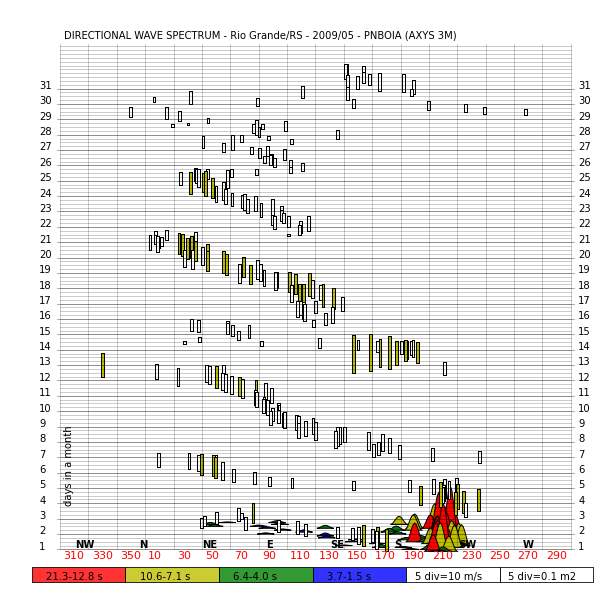

In [307]:
'''
PLEDS - Parente's Diagram
'''

#wave
espe1 = espe[:,:-1:3] * 2
dire1 = dire[:,:-1:3]
energ1 = energ[:,:-1:3]

#wind
ws1 = ws[:-1:3]
wd1 = wd[:-1:3]

#plot PLEDS
pleds.pleds(espe1,dire1,ws1,wd1)

(0.48931084138624475, 1.9874146242178643, 0.0, 2.0)

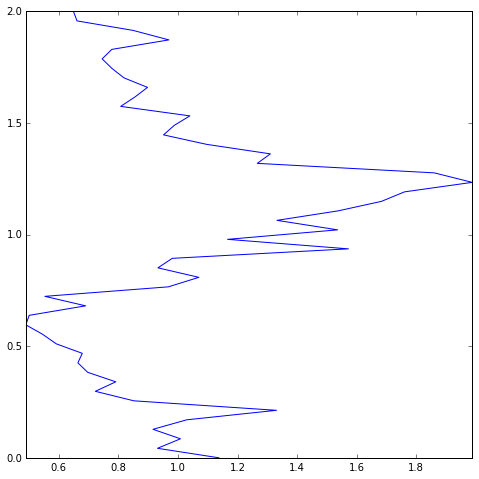

In [308]:
'''
plota energia de cada faixa
'''

a = np.linspace(0,espe.shape[1]/24,espe.shape[1])

pl.figure(figsize=(8,8))
pl.plot(energ[4,:],a)
pl.axis('tight')

In [309]:
toc = timem.clock()
texec = toc - tic
print 'Tempo de execucao DAAT (s): ', texec

Tempo de execucao DAAT (s):  47.282258


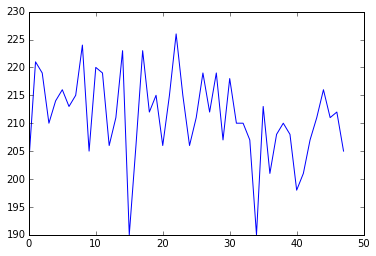

In [310]:
plot(dire[0,:])